In [ ]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import os
from ourmodel import PATN,Gender_Inference_Model
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt


os.environ["CUDA_VISIBLE_DEVICES"] = "3"
device = torch.device("cuda:3")
def get_ds_infos():
    dss = pd.read_csv("./A_DeviceMotion_data/data_subjects_info.csv").values
    print("[INFO] -- Data subjects' information is imported.")
    return dss


## Take out the test data
def read_data(dir,num, chang):
    raw_data = pd.read_csv(dir)
    data = np.array(raw_data.values)
    data = data[:int(0.7 * len(data)), -6:]
    n = len(data)
    i = 0
    slicedData = []
    furdata =[]
    while i < (n - num -chang):
        if i == 0:
            slicedData = np.array([data[i:i+num]])
            furdata = np.array([data[i+num:i+num+chang]])
        else:
            slicedData = np.concatenate((slicedData, np.array([data[i:i+num]])), axis = 0)
            furdata = np.concatenate((furdata, np.array([data[i+num :i+num+chang]])), axis = 0)
        i += chang
    return slicedData,furdata

def sliding_window_reshape(data, window_size=30, step_size=30):

    M, feature_dim = data.shape
    slices = []

    for start in range(0, M - window_size + 1, step_size):
        window = data[start:start + window_size]
        slices.append(window)

    result = np.stack(slices, axis=0)
    return result

act_dict = {'dws':0,'jog':1,'sit':2,'std':3,'ups':4,'wlk':5}

def compute_eer(labels, scores):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    eer_index = np.nanargmin(abs_diffs)
    eer = (fpr[eer_index] + fnr[eer_index]) / 2
    return eer

## Load model
adv_model = PATN().to(device)
adv_model.load_state_dict(torch.load("./model/PATN_model.pth"))

##perturbtion range
perturb_limits = torch.tensor([0.06451838 , 0.06075889, 0.04009763, 0.0160811,  0.02619115, 0.018439]).to(device)
target_model = Gender_Inference_Model().to(device)
target_model.load_state_dict(torch.load("./model/Gender_model.pth"))

<All keys matched successfully>

[INFO] -- Data subjects' information is imported.


0it [00:00, ?it/s]
100%|██████████| 24/24 [00:00<00:00, 25.71it/s]


ACC: 0.9145
AUC: 0.9793
EER: 0.0830
F1-score: 0.9284


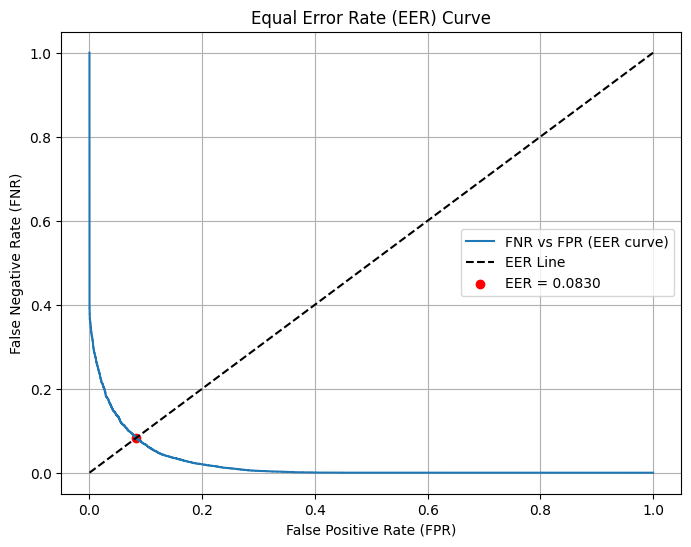

In [ ]:
#Test raw data
i = 0
t = 0
correct,total = 0,0
num_correct_clean = 0
num_success_attacks = 0
adv_model.eval()
target_model.eval()
dss = get_ds_infos()
all_preds1 = []
all_labels1 = []
all_probs1 = []
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
 # Path to the dataset
ch = os.walk('./A_DeviceMotion_data')
for path, dir_list, file_list in ch:  
    for file_name in tqdm(file_list):
        t += 1
        result = read_data(os.path.join(path, file_name), 30, 10)
        if result is None or result[0] is None or result[1] is None:
            continue  # Skip if data reading failed

        data, furdata = result
        label_gender = int(dss[int(file_name.split('_')[-1].split('.')[0]) - 1][-1])
        data = torch.tensor(data, dtype=torch.float32).to(device)
        furdata = torch.tensor(furdata, dtype=torch.float32).to(device)
        delta = adv_model(data)
        limits = perturb_limits.unsqueeze(0).unsqueeze(0).expand_as(delta)
        adv_perturb = torch.clamp(delta, -limits, limits)
        furdata_adv = furdata 
        labels = torch.tensor([label_gender] * len(furdata_adv)).to(device)
        group_size = 5
        with torch.no_grad():
            outputs_clean = target_model(furdata)
            outputs_adv = target_model(furdata)
            #  group_size 
            num_groups = len(outputs_clean) // group_size

            for i in range(num_groups):
                clean_group = outputs_clean[i * group_size:(i + 1) * group_size]
                adv_group = outputs_adv[i * group_size:(i + 1) * group_size]
                label_group = labels[i * group_size:(i + 1) * group_size]

                avg_clean_output = clean_group.mean(dim=0)
                avg_adv_output = adv_group.mean(dim=0)

                pred_clean = torch.argmax(avg_clean_output).item()
                pred_adv = torch.argmax(avg_adv_output).item()
                true_label = label_group[0].item()  

                # accuracy
                if pred_adv == true_label:
                    correct += 1
                total += 1

                # ASR
                if pred_clean == true_label and pred_adv != true_label:
                    num_correct_clean += 1
                    num_success_attacks += 1

                prob = torch.softmax(avg_adv_output, dim=0)[1].item()
                all_probs1.append(prob)
                all_labels1.append(true_label)


## output results

acc = correct / total
print(f'ACC: {acc:.4f}')
if len(np.unique(all_labels1)) == 2:
    # AUC
    auc = roc_auc_score(all_labels1, all_probs1)
    print(f'AUC: {auc:.4f}')
    
    # ROC metrics
    fpr, tpr, thresholds = roc_curve(all_labels1, all_probs1)
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.absolute(fnr - fpr))
    eer = fpr[eer_idx]
    print(f'EER: {eer:.4f}')
    pred_labels = (np.array(all_probs1) >= 0.5).astype(int)
    f1 = f1_score(all_labels1, pred_labels)
    print(f'F1-score: {f1:.4f}')
    plt.figure(figsize=(8,6))
    plt.plot(fpr, fnr, label='FNR vs FPR (EER curve)')
    plt.plot([0, 1], [0, 1], 'k--', label='EER Line')
    plt.scatter(fpr[eer_idx], fnr[eer_idx], c='red', label=f'EER = {eer:.4f}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('False Negative Rate (FNR)')
    plt.title('Equal Error Rate (EER) Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

else:
    print("error")


[INFO] -- Data subjects' information is imported.


0it [00:00, ?it/s]
100%|██████████| 24/24 [00:00<00:00, 34.25it/s]


Adversarial Success Rate (ASR): 40.10% (7107/17722)
ACC: 0.5923
AUC: 0.6620
EER: 0.4165
F1-score: 0.6109


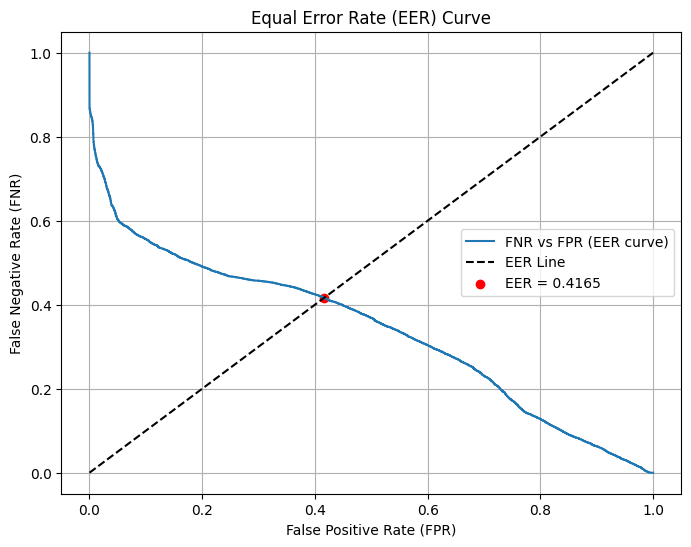

In [ ]:
# test PATN
i = 0
t = 0
correct,total = 0,0
num_correct_clean = 0
num_success_attacks = 0
dss = get_ds_infos()
all_preds = []
all_labels = []
all_probs = []

adv_model.eval()
target_model.eval()
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# Path to the dataset
ch = os.walk('./A_DeviceMotion_data/A_DeviceMotion_data')
for path, dir_list, file_list in ch:  
    for file_name in tqdm(file_list):
        t += 1
        result = read_data(os.path.join(path, file_name), 30, 10)
        if result is None or result[0] is None or result[1] is None:
            continue  # Skip if data reading failed

        data, furdata = result
        label_gender = int(dss[int(file_name.split('_')[-1].split('.')[0]) - 1][-1])
        data = torch.tensor(data, dtype=torch.float32).to(device)
        furdata = torch.tensor(furdata, dtype=torch.float32).to(device)
        # PATN
        delta = adv_model(data)
        limits = perturb_limits.unsqueeze(0).unsqueeze(0).expand_as(delta)
        adv_perturb = torch.clamp(delta, -limits, limits)
        furdata_adv = furdata + adv_perturb
        labels = torch.tensor([label_gender] * len(furdata_adv)).to(device)
        group_size = 5
        with torch.no_grad():
            outputs_clean = target_model(furdata)
            outputs_adv = target_model(furdata_adv)
            #  group_size 
            num_groups = len(outputs_clean) // group_size

            for i in range(num_groups):
                clean_group = outputs_clean[i * group_size:(i + 1) * group_size]
                adv_group = outputs_adv[i * group_size:(i + 1) * group_size]
                label_group = labels[i * group_size:(i + 1) * group_size]

                avg_clean_output = clean_group.mean(dim=0)
                avg_adv_output = adv_group.mean(dim=0)

                pred_clean = torch.argmax(avg_clean_output).item()
                pred_adv = torch.argmax(avg_adv_output).item()
                true_label = label_group[0].item()  

                # accuracy
                if pred_adv == true_label:
                    correct += 1
                total += 1

                # ASR 
                if pred_clean == true_label:
                    num_correct_clean += 1
                    if pred_adv != true_label:
                        num_success_attacks += 1

                prob = torch.softmax(avg_adv_output, dim=0)[1].item()
                all_probs.append(prob)
                all_labels.append(true_label)



if num_correct_clean > 0:
    asr = num_success_attacks / num_correct_clean * 100
    print(f"Adversarial Success Rate (ASR): {asr:.2f}% ({num_success_attacks}/{num_correct_clean})")
else:
    print("No originally correctly classified samples to compute ASR.")


acc = correct / total
print(f'ACC: {acc:.4f}')

if len(np.unique(all_labels)) == 2:
    # AUC
    auc = roc_auc_score(all_labels, all_probs)
    print(f'AUC: {auc:.4f}')
    
    # ROC metrics
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    
    # EER
    eer_idx = np.nanargmin(np.absolute(fnr - fpr))
    eer = fpr[eer_idx]
    print(f'EER: {eer:.4f}')

    pred_labels = (np.array(all_probs) >= 0.5).astype(int)
    f1 = f1_score(all_labels, pred_labels)
    print(f'F1-score: {f1:.4f}')

    plt.figure(figsize=(8,6))
    plt.plot(fpr, fnr, label='FNR vs FPR (EER curve)')
    plt.plot([0, 1], [0, 1], 'k--', label='EER Line')
    plt.scatter(fpr[eer_idx], fnr[eer_idx], c='red', label=f'EER = {eer:.4f}')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('False Negative Rate (FNR)')
    plt.title('Equal Error Rate (EER) Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

else:
    print("error")
